## Creating Drug and Target embeddings for Exploratory Bioinformatics

In this notebook, the knowledge graph from DrugBank is used to create embeddings for drugs and genes, by exploiting their interaction graph.
This notebook contains both dataset pre-processing, training, and some visualizations to qualitatively assess the method.

The current notebook uses random embeddings for initializationfor each drug and gene, but it will be extended to using more information (e.g., protein or drug embeding models).

The graph links are attributed, because there are several qualitatively different drug-target relations. The self-supervised task to train the embedings is (currently) a *link prediction* task, defined in such a way that it is computationally efficient to compute per-batch. The Mini-batches are created by the following procedure:

1. A random set of drugs is selected
2. A subset of the interactions of these grugs with their respective subset is selected (i.e., a *drug-centered* graph).
3. The neighborhoods (i.e., drugs that interact with these targets) of the selected targets are sampled (which can include the source drug nodes) (i.e., a *target-centered graph*). 

For the negative samples, the edges of these subgraphs are permuted in such a way that targets and drugs are connected with targets and drugs that are in the same batch, but no target or drug is connected with one of the "real" connections. This is called a "derangement". This technique is very computationally efficient. Moreover, the "negative" drugs (in the protein-centered graph) may be close in the graph, therefore at some level these are "hard" negatives (i.e., non-trivially different nodes).

![alt-img](https://raw.githubusercontent.com/mylonasc/drug-discovery-gnns/main/assets/edge-prediction-task.png)


The link prediction task is a binary task, but the inputs to the GNN are attributed. Using a softmax for multi-class classification may have some issues due to the low number of examples for some relations. At the momen the relation embeddings are not trained.


## Using pre-trained embeddings for proteins and drugs 
It is possible to attach more information on nodes of the graph or use the node information to define a contrastive learning embeding. This is left as future work. At the moment, the prot-T5 model embedings are already integrated in the code but un-used.

## Knowledge graph refs for drug repurposing

|Date|Title|Link|Approach/notes|
|---|---|---|---|
| 08-01-2019  | Discovering protein drug targets using knowledge graph embeddings | [link](https://aran.library.nuigalway.ie/bitstream/handle/10379/15375/main_dti.pdf;jsessionid=DED09659DD7154C06E2E6DFE73C18213?sequence=1)| Link prediction in knowledge graphs|
| 2023-ICLR | Protein representation learning bia knowledge-enhanced primary structure modeling| [link](https://www.biorxiv.org/content/10.1101/2023.01.26.525795v1.full.pdf) | Masked language model for aminoacids, language embs |
|2022-ICLR |OntoProtein: Protein pretraining with gene ontology embedding | [link](https://arxiv.org/pdf/2201.11147.pdf)|Masked language models + gene ontology knowledge graph use|
|31-01-2022| A knowledge graph to interpret clinical proteomics data |[link](https://www.nature.com/articles/s41587-021-01145-6) | Clinical knowledge graph - no ML. "Clinical proteomics" - may be used to extend the work to clinical/disease data.|
|2020-Nature|Preclinical validation of therapeutic targets predicted by tensor factorization on heterogeneous graphs | [link](https://www.nature.com/articles/s41598-020-74922-z.epdf?sharing_token=9g5nJI1kxkoZN02KQ4PqcdRgN0jAjWel9jnR3ZoTv0P9D9RrU4AAqO3Z-w2ZIYdnJNBD_lL2uovY6Q_qmY4OEC6tB3uqFlmfju-HLeKNbAJDGoiN7Sg8gxqWwy2vJwCXe4YkeXIVeHu2k1B1Som41XusV8f8JV_ygMXNEBbkYgk%3D) | BenevolentAI work | 
|2022-Nature| Affinity2Vec: drug-target binding affinity prediction through representation learning, graph mining, and machine learning |[link](https://www.nature.com/articles/s41598-022-08787-9) | References a lot of interesting work on the topic of Drug-Target-Binding Affinity (DTBA) problem. Useful for extensions that contain more refined edge features. |
|2022-PMLR| Graph-Text Multi-Modal Pre-training for Medical Representation Learning  | [link](https://proceedings.mlr.press/v174/park22a/park22a.pdf)| Cross-modal contrastive pre-training with focus on EHR last author is E. Choi (author of GRAM)|

## Useful models/resources
|Model|Link|Description|
|---|---|---|
|OntoProtein | [HuggingFace link](https://huggingface.co/zjunlp/OntoProtein) | The OntoProtein model (see papers above) |
|Colab for ProtT5| [notebook link](https://colab.research.google.com/drive/1TUj-ayG3WO52n5N50S7KH9vtt6zRkdmj?usp=sharing#scrollTo=6OC1toF1EM9n)| A ProtT5 model in high-precission (so it can be run in google colab)|
|CLUE: The drug repurposing hub (case studies)| [link](https://clue.io/repurposing#case-studies) | Check out for inspiration on what to do with the trained model (and how to define training objectives)|
|A Deep Learning Approach to Antibiotic Discovery|[link](https://www.cell.com/cell/fulltext/S0092-8674(20)30102-1)| The high-profile success story of Halicin case (often cited as a success of GNNs).|
|NA| [Youtube link](https://www.youtube.com/watch?v=0iaeD0BSByw) | Recent video (March '23) from Avi Ma'ayan on his lab's work related to bioinformatics KGs. Relevant for extensions to phenotype data, or in general linking to other KGs. |
|ΝΑ|[github link](https://github.com/benb111/awesome-small-molecule-ml#papers-adme-tox)| "Awesome" list with small mollecule deep learning works.|


## Progress
### Preparation/Pre-processing
* Cleaned DrugBank KG (in retrospect there are other KGs that are freely available for reproducibility)
* Computed protein embeddings with a half-precission version of `ProtT5` (currently un-used)
* Filtered targets/drugs/relations that do not have enough data (left with some 1000s of nodes for drugs and targets and 11 different types of "relations" (with `other` being the most common). The relations with few instances are included as "other".
* Wrote the sampler/negative sampler and a very efficient `tf.function` traced creation function for the graph tuples.
* Adapted the `mylonasc/tf_gnns` library (my library) to easilly create MPNNs with no global features and wrote tests for the new implementation (may help with cleaner and more efficient)

### Training
Adam with learning rate 0.0001 is used (as of course is tradition). At each epoch the sequence of drug indices used is permutted. This has to do with the training objective, and it has the effect of creating negative samples from different neighborhoods for each epoch. In the absense of this, the network would learn how to discriminate drugs and targets only from particular other drugs targets, leading to over-fitting.

### Validation
Currently only a qualitative validation is done. Namely, it is observed if drugs that have similar embeddings indeed have some similarities. Indeed this happens for the current procedure (figures to follow). 

### Ideas
* Use mollecular properties and/or BioBERT embeddings (in addition to the graph embeddings) for learning the representations.
* Implement cross-modal contrastive techniques (like CLIP) (there is a [paper on that from E. Choi's group](https://proceedings.mlr.press/v174/park22a/park22a.pdf)).

In [ ]:
#@title Installs (`ProtT5` needs `transformers` and `SentencePiece`)
INSTALL_TRANSFORMERS = True #@param {'type' : 'boolean'}
if INSTALL_TRANSFORMERS:
    !pip install SentencePiece
    !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tf_gnns==0.1.5a2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title `ProtT5` model (not essential - can use pre-computed embeddings)
from transformers import T5EncoderModel, T5Tokenizer
import torch
class ProtT5EmbModel:
    def __init__(
        self, 
        model_string : str= "Rostlab/prot_t5_xl_half_uniref50-enc", 
        device : str= 'cuda:0'):
        """
        ProtT5EmbModel:

        a quick and dirty inference for ProtT5 model. The max sequence computable 
        with colab is ~4.5k aminoacids.

        """
        self.model_string = model_string
        self.device = device
        self._get_model()
        self.model, self.tokenizer = self._get_model()

    def _get_model(self):
        model = T5EncoderModel.from_pretrained(self.model_string)
        model = model.to(device) # move model to GPU
        model = model.eval() # set model to evaluation mode
        tokenizer = T5Tokenizer.from_pretrained(self.model_string, do_lower_case=False)
        return model, tokenizer

    def _compute_on_targets(self,targets_and_sequences : dict):
        """
        Given a dictionary of target:sequence (in fasta format) compute the
        embeddings.
        """
        #sort to maybe enable batching (not extremely helpful - the problem is
        #  the larger sequences)

        self.seq_dict = sorted( targets_and_sequences.items(), key=lambda kv: len( targets_and_sequences[kv[0]] ), reverse=True )

    def _comp(
        self,
        inds_to_compute
        ):
        
        try:
            seqs = [' '.join(self.seq_dict[i][1]) for i in inds_to_compute]
            token_encoding = self.tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
            input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)
            with torch.no_grad():
                # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
                emb_repr = self.model(input_ids, attention_mask=attention_mask)
            return emb_repr['last_hidden_state'].mean(-2).detach().cpu().numpy()
        except:
            print("RuntimeError during embedding")
    
    def _comp_all(
        self,
        file_to_save_at = 'protein_embeddings_file.pd',
        max_seq_len = 4563,
        save_every = 100
        ):
        """
        Computing with single example in batch (~40mins for ~4k proteins with max length 4k aminoacids)
        """
        results = {}
        # manually selected - memory limmitations do not allow very large proteins.
        start_idx = 10 
        for sd in tqdm(range(0, len(self.seq_dict))):
            if len(self.seq_dict[sd][1]) > max_seq_len:
                print('target {} larger than max_seq_len ({}). Did not compute.'.format(self.seq_dict[sd][0],len(self.seq_dict[sd][1])))
                continue
            res = self._comp([sd])
            results[self.seq_dict[sd][0]] = [res[0].astype('float16')]
            if (sd+1) % save_every == 0:
                pd.DataFrame(results).T.to_pickle(os.path.join(data_root_folder,file_to_save_at))
                print('saving to' + os.path.join(data_root_folder,file_to_save_at))

        pd.DataFrame(results).T.to_pickle(os.path.join(data_root_folder,file_to_save_at))

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as pplot

import xml.etree.ElementTree as ET

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Where to save or load from the datasets

import os
# !mkdir /content/gdrive/MyDrive/datasets
# !mkdir /content/gdrive/MyDrive/datasets/DrugDiscovery
data_root_folder = '/content/gdrive/MyDrive/datasets/DrugDiscovery' #@param {type : 'string'}
os.environ['DATA_ROOT_FOLDER'] = data_root_folder
DOWNLOAD_DATA = False #@param {type : 'boolean'}
PREP_DATA = False #@param {type : 'boolean'}
CREATE_SUBGRAPH = False #@param {type : 'boolean'}
PROT_EMB_PATH = os.path.join(data_root_folder,'protein')
PROT_EMB_PATH_HalfPrec = os.path.join(data_root_folder, 'computed_protT5_uniprot_half_precission.pd')

In [ ]:
#@title Downloading and preparation of data (if neccessary)
if DOWNLOAD_DATA:
    # For drug-gene interactions
    !wget --directory-prefix=$DATA_ROOT_FOLDER https://snap.stanford.edu/biodata/datasets/10002/files/ChG-Miner_miner-chem-gene.tsv.gz

    # for gene naming
    !wget --directory-prefix=$DATA_ROOT_FOLDER https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/json/hgnc_complete_set.json

    # drug ontology (not drugbank! - the drug-disease interaction graph is using drugbank IDs!)
    # !wget https://kg-hub.berkeleybop.io/kg-obo/dron/2022-04-22/dron.json

    # see https://www.uniprot.org/help/downloads#embeddings
    # and https://www.uniprot.org/help/embeddings for source of the embeddings. 
    # This is a "pre-alphafold1" transformer repr. learning technique for aminoacids 
    # using the "ProtT5" model.
    !wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5
    !mkdir $DATA_ROOT_FOLDER/prot-embedings/ && mv per-protein.h5 $DATA_ROOT_FOLDER/prot-embedings/per-protein.h5

if PREP_DATA:
    !mkdir drugbank_data && mkdir drugbank_data/drug_data %mkdir drugbank_data/target_data
    !cd drugbank_data/drug_data && unzip $DATA_ROOT_FOLDER/drugbank_all_full_database.xml.zip 
    !cd drugbank_data/target_data && unzip $DATA_ROOT_FOLDER/drugbank_all_target_polypeptide_ids.csv.zip
    !cp -r $DATA_ROOT_FOLDER/prot-embedings.h5 . 

df_drug_gene = pd.read_csv(os.path.join(data_root_folder,'ChG-Miner_miner-chem-gene.tsv.gz'), compression='gzip', header=0, sep='\t')
# target_ids = pd.read_csv('drugbank_data/target_data/all.csv')

SUBGRAPH_PATH = os.path.join(data_root_folder,'drugbank_subgraph')


# If subgraph is not created it is loaded from disk.
if CREATE_SUBGRAPH:

    def _get_drug_drug(adv_eff_elm):
        d = {}
        for i in adv_eff_elm:
            d[_strip_tag_text(i.tag)] = i.text
        return d

    def _proc_child(child, drugs_to_keep = []):
        # to get drug-drug interactions of for a drug:
        db_id = [d.text for d in _findall(child, 'drugbank-id') if 'DB' in d.text]
        # db_id = db_id[0]
        _id = None
        for _db_id in db_id:
            if _db_id in drugs_to_keep:
                _id = _db_id
                break

        if _id is None:
            return None

        d = {'drugbank-id' : _id}
        for c in _findall(child, 'drug-interactions'):
            all_inters = [];
            for cc in c:
                all_inters.append(_get_drug_drug(cc))
        d['drug-interactions'] = all_inters
        d['description'] = _find(child, 'description').text

        return d

    tree = ET.parse('drugbank_data/drug_data/full database.xml')
    root = tree.getroot()

    keep_list = set(df_drug_gene['#Drug'].unique())
    subgraph_drug_data = []
    for child in root:
        res = _proc_child(child, drugs_to_keep = keep_list)
        if res is not None:
            subgraph_drug_data.append(res)
            
    subgraph_drug_data_df = pd.DataFrame(subgraph_drug_data)
    subgraph_drug_data_df.to_csv(SUBGRAPH_PATH)
    # del tree
else:
    subgraph_drug_data_df = pd.read_csv(SUBGRAPH_PATH)
    

In [ ]:
#@title Pre-proc DrugDank data to get subgraph (also pre-computed). If `False`, reads from disc.
DRUGBANK_GRAPH_DATA_PROC = False #@param {'type' : 'boolean'}
SUBGRAPH_FILE_NAME = 'drugbank_subgraph_v3' #@param ['drugbank_subgraph_v2', 'drugbank_subgraph_v3']
def _strip_tag_text(v):
    return v[24:]

def _find(cc,tag):
    return cc.find('{http://www.drugbank.ca}' + tag)

def _findall(cc,tag):
    return cc.findall('{http://www.drugbank.ca}' + tag)

# SUBGRAPH_PATH_v2 = os.path.join(data_root_folder,'drugbank_subgraph_v2')
SUBGRAPH_PATH = os.path.join(data_root_folder,'drugbank_subgraph_v3')
if DRUGBANK_GRAPH_DATA_PROC:
    def _get_actions(actions_element):
        r = []
        for a in actions_element:
            r.append({_strip_tag_text(a.tag) :  a.text})
        return r

    def _get_polypeptide(polypeptide_element):
        keep_tags = ['name','general-function','amino-acid-sequence']
        dat = {}
        dat.update({polypeptide_element.items()[0][0] : polypeptide_element.items()[0][1]})
        for p in polypeptide_element:
            tt = _strip_tag_text(p.tag)
            if tt in keep_tags:
                dat[tt] = p.text
        return dat
        
    def _get_target(target_element):
        scrape_strategies = {'actions' : _get_actions ,'polypeptide' : _get_polypeptide}
        dtarg = []
        for p in target_element:
            
            dtarg_d = {}
            for pp in p:
                tt = _strip_tag_text(pp.tag)
                if tt in scrape_strategies:
                    dtarg_d[tt] = scrape_strategies[tt](pp)
            dtarg.append(dtarg_d)
        return dtarg

    def _proc_drug_elm(d):
        dd = {}
        for d_ in d:
            dd[_strip_tag_text(d_.tag)] = d_.text
        return dd

    def _proc_iter(cc,tag):
        tt = '{http://www.drugbank.ca}' + tag
        res = {}
        for c in cc:
            if tag == 'enzymes':
                if tag not in res:
                    res[tag] = [c.text]
                else:                
                    res[tag].append(c.text)
            if tag == 'drugs':
                if tag in res:
                    res[tag].append(_proc_drug_elm(c))
                else:
                    res[tag] = [_proc_drug_elm(c)]
        return res


    def _get_pathways_element(pathways_elm):
        pathways = []
        all_pw_dat = {}
        for p in pathways_elm:
            keep_tags = ['category','name','smpdb-id']
            for p_ in p:
                tt = _strip_tag_text(p_.tag)
                if tt in ['drugs', 'enzymes']:
                    res = _proc_iter(p_, tt)
                    all_pw_dat.update(res)

                if tt in keep_tags:
                    all_pw_dat[tt] = p_.text
            pathways.append(all_pw_dat)
            all_pw_dat = {}
        return pathways

    def _small_mol(c):
        """
        to parse the small molecule data
        """
        tags_to_keep_text = ['drugbank-id','name','description','indication','mechanism-of-action']
        res_dict = {}
        for c_ in c:
            tt = _strip_tag_text(c_.tag)
            if tt in tags_to_keep_text:
                res_dict[tt] = c_.text
            if tt == 'pathways':
                res_dict[tt] = _get_pathways_element(c_)
            if tt == 'targets':
                res_dict[tt] = _get_target(c_)
        return res_dict

    def _biotech(c):
        """
        to parse the biotech data
        """
        return _small_mol(c)

    drug_centric = []
    for c in root:
        if c.items()[0][1] == 'small molecule':
            p = _small_mol(c)
        if c.items()[0][1] == 'biotech':
            p  = _biotech(c)
        drug_centric.append(p)
    dbdata = pd.DataFrame(drug_centric)
    dbdata.to_pickle(SUBGRAPH_PATH)
else:
    dbdata = pd.read_pickle(SUBGRAPH_PATH)

  0%|          | 0/15235 [00:00<?, ?it/s]

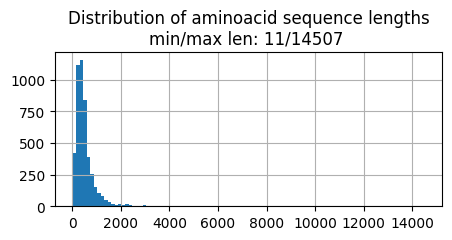

In [ ]:
#@title Visualization of polypeptide sizes (colab GPU can handle up to 4.5k residues)
## Compute all targets and sequences
from tqdm.auto import tqdm

def _replace_nonstandard(s):
    """
    From the ProtT5 code (see "useful resources" in the top) check - read_fasta
    """
    return s.replace('U','X').replace('Z','X').replace('O','X')

targets_and_sequences = {}
for t in tqdm(dbdata['targets']):
    for tt in t:
        if 'polypeptide' in tt:
            ppt = tt['polypeptide']['id']

            if ppt in targets_and_sequences:
                continue
            seq = ''.join(tt['polypeptide']['amino-acid-sequence'].split('\n')[1:])
            seq = _replace_nonstandard(seq)
            targets_and_sequences[ppt] = seq     

targ_len = [len(ss) for tt, ss in targets_and_sequences.items()]
p = pplot.figure(figsize = (5,2), dpi = 100)
p = pplot.hist(targ_len, 100)
max_seq, min_seq = max(targ_len), min(targ_len)
pplot.title('Distribution of aminoacid sequence lengths\nmin/max len: %i/%i '%(min_seq, max_seq))
pplot.grid()
pplot.show()

In [ ]:
# !pip install rdkit

In [ ]:
computed_prot_emb = pd.read_pickle(PROT_EMB_PATH_HalfPrec)
target_emb_dict = {k : v for k, v in computed_prot_emb.reset_index().values}

In [ ]:
computed_prot_emb

,0
P04114,"[0.0413, -0.1171, -0.01254, 0.03058, -0.01344,..."
P08519,"[0.1737, 0.1521, -0.01371, 0.1003, 0.0992, 0.0..."
Q07954,"[0.02309, 0.05316, 0.0623, 0.04175, -0.02142, ..."
P0DTC1,"[0.01039, -0.05624, 0.001566, 0.0801, 0.00258,..."
P98160,"[0.003035, 0.0462, 0.0515, 0.000439, -0.00786,..."
...,...
P0C1V1,"[0.012314, -0.08545, 0.09296, 0.003925, 0.0337..."
Q16498,"[0.0614, 0.0352, -0.04218, -0.0548, 0.0627, 0...."
O43519,"[0.10394, 0.02731, -0.09735, -0.01855, 0.00053..."
P0C2S2,"[0.147, 0.0628, -0.08606, -0.10345, -0.001795,..."


In [ ]:
# remove the targets that have no embeddings:
no_emb_targets = set(targets_and_sequences.keys()) - set(target_emb_dict.keys())
for t in no_emb_targets:
    print(t, len(targets_and_sequences[t]))


K9N7C7 7078
P0DTD1 7096
Q8WXI7 14507
Q92736 4967
Q5T4S7 5183
Q98VG9 6709
P21817 5038
Q02817 5179
P0C6X7 7073
P98164 4655


## Data cleaning
* Removing entries that do not contain "targets"
* removing experimentals, bio-factors and others ("`AP?`") that seem to have limmited graph data
* cleaning-up some of the relations (some of them have very few occurences)
* remove some targets 
  * rare targets
  * targets for which I cannot compute embeddings for using the available models (more than 4.5k residues)
  * it is possible to associate them with other targets - e.g., with pathway data or with sequence alignment, but at this stage  I'll neglect that



In [ ]:
def _clean_action_data(a):
    """
    Some combined actions are rare or have slightly different
    naming (e.g., binding/binder). This is used to consolidate them
    """
    if a == 'binder':
        return 'binding'
    if a in ['inhibition of synthesis','blocker']:
        # not the same, but could may be close:
        return 'inhibitor'
    if a == 'other/unknown':
        return 'other'
    return a

def _action_data_multi_clean(a):
    if 'downregulator' in a:
        return ['downregulator']
    if 'inhibitor' in a:
        return ['inhibitor']

    if 'antagonist' in a and 'binding' in a:
        return ['antagonist']

    if 'agonist' in a and 'binding' in a:
        return ['agonist']

    if 'antagonist' in a and 'agonist' in a:
        return ['agonist-antagonist'] # https://en.wikipedia.org/wiki/Agonist-antagonist

    if 'antagonist' in a and 'regulator' in a:
        return ['antagonist']

    if 'inhibitor' in a and 'antibody' in a:
        return ['inhibitor']
    if 'modulator' in a :
        return ['modulator']
    return a
    
    
def _get_interacting_proteins(x):
    res = []
    for e in x:
        if len(e['actions']) > 0:
            action_dat = []
            for ee in e['actions']:
                action_dat.append(_clean_action_data(ee['action']))
            action_dat = _action_data_multi_clean(action_dat)
        else:
            action_dat = ['other']
        if 'polypeptide' in e:
            res.append((action_dat[0], e['polypeptide']['id'], ))
        
    return res

def _keep_drug_id(x):
    return x[0:2] != 'BI' and x[0:2] != 'AP' and x[0:2] != 'EX' and 'SALT' not in x

def _keep_target_ids(x):
    """
    Filter out the targets for which I cannot compute embeddings due to computational 
    limmitations
    """
    
    tt = []
    for t in x:
        if 'polypeptide' in t:
            if t['polypeptide']['id'] in no_emb_targets:
                continue
            else:
                tt.append(t)    
    return tt
filtered_target_idx = dbdata.targets.apply(_keep_target_ids)
# filtered_target_idx = dbdata.targets
dbdata_f = dbdata[filtered_target_idx.apply(lambda x : len(x) > 0)] 
dbdata_f = dbdata_f[dbdata_f['drugbank-id'].apply(_keep_drug_id)]
# target_actions = dbdata_f['targets'].apply(lambda x : '.'.join([a['action'] for a in x[0]['actions']]))
# dbdata_f['target_actions'] = target_actions
targets = dbdata_f['targets'].apply(_get_interacting_proteins) # protein-to-drug
drugs = dbdata_f['drugbank-id'] # drug-to-protein
pathways = dbdata_f['pathways'] # currently unused

In [ ]:
dbdata_f.iloc[0]['indication']

'For treatment of heparin-induced thrombocytopenia and for the prevention of thrombosis. Bivalirudin is indicated for use in patients undergoing percutaneous coronary intervention (PCI), in patients at moderate to high risk acute coronary syndromes due to unstable angina or non-ST segment elevation in whom a PCI is planned.'

In [ ]:
relations_count = {}
protein_targets_count = {}

for t in targets.values:
    for rel, targ in t:
        # rel= '.'.join(rel)
        if rel not in relations_count:
            relations_count[rel] = 1
        else:
            relations_count[rel] += 1

        if targ not in protein_targets_count:
            protein_targets_count[targ] = 1
        else:
            protein_targets_count[targ] += 1

In [ ]:
data= np.vstack([v for v in target_emb_dict.values()])
from sklearn.manifold import TSNE
# res = TSNE().fit_transform(data)

In [ ]:
# import matplotlib.pyplot as pplot
# pplot.plot(res[:,0],res[:,1],'.')
# pplot.title("Protein emb. TSNE")

In [ ]:
#@title further cleaning to filter-out drugs and targets with too few relations and relations that take part in too few interactions
THRESH_KEEP_TARGET = 1  #@param {'type' : 'integer'}
THRESH_KEEP_RELATION = 30 #@param {'type' : 'integer'} rare relations set to "other"

all_relations = sorted([(k,v) for k,v in relations_count.items()], key = lambda x: x[1], reverse = 1)
relations_to_keep = [k for k, v in relations_count.items() if v > THRESH_KEEP_RELATION]
targets_filtered = {k : v for k, v in protein_targets_count.items() if v >= THRESH_KEEP_TARGET}

def _filter_relations_and_targets(targets):
    res = []
    for relation, target in targets:
        if relation not in relations_to_keep:
            relation = 'other'
        if target not in targets_filtered:
            continue
        res.append((relation, target))
    return res

targf_2 = targets.apply(_filter_relations_and_targets)
filt_idx = targf_2.apply(lambda x : len(x) > 1)
filtered_targets = targf_2[filt_idx]
filtered_drugs = drugs[filt_idx]

filtered_drugs = filtered_drugs.apply(lambda x : x.replace('SALT',''))

In [ ]:
relations_list = filtered_targets.values
drugs_list = filtered_drugs.values
proteins, relations = [] , []
for rels in relations_list:
    for r in rels:
        relation, protein = r
        proteins.append(protein)
        relations.append(relation)
proteins = np.unique(proteins)
relations = np.unique(relations)

target_to_drug = {}
for r,drug in zip(filtered_targets, filtered_drugs):
    for rel_, targ_ in r:
        if targ_ in target_to_drug:
            target_to_drug[targ_].append( (drug, rel_) )
        else:
            target_to_drug[targ_] = [(drug, rel_)]

print('drugs: %i\nprotein targets: %i\ndrug-target relations: %i'%(len(filtered_drugs), len(proteins), len(relations)))

drugs: 1285
protein targets: 1236
drug-target relations: 15


## Preprocessing...

* currently although they are available, the pre-computed ProtT5 embedings are not used. (`TODO`).
* It is also interesting to use some molecular embedings (e.g., from RDKit or from some pre-computed GNN).(`TODO`).

In [ ]:
#@title initializing the embeddings (`emb_prot`, `emb_rel`, `emb_dr`)
import numpy as np
import tensorflow as tf

EMB_SIZE = 256 #@param {type : 'integer'}
graph_entities = [proteins, relations, filtered_drugs]
np.random.seed(132)
emb_names = ['prot','rel','dr']
emb_prot, emb_rel, emb_dr = \
  [tf.Variable(np.random.randn(len(n_), EMB_SIZE).astype('float32')/np.sqrt(EMB_SIZE), trainable = True, name = nn_) for n_, nn_ in zip(graph_entities,emb_names)]


dict_drug_idx = {d : i for i, d in enumerate(filtered_drugs.values)}
dict_rel_idx = {r : i for i, r in enumerate(relations)}

dict_prot_idx = {p : i  for i, p in enumerate(proteins)}

In [ ]:
emb0_prot = emb_prot.numpy()
emb0_dr = emb_dr.numpy()

In [ ]:
prots_w_no_emb = set(dict_prot_idx.keys()) -  set(target_emb_dict.keys())
print("Proteins in the filtered dataset that have no pre-computed embeding:")
print( prots_w_no_emb)

Proteins in the filtered dataset that have no pre-computed embeding:
{'K9N7C7', 'P0DTD1', 'Q98VG9', 'P21817', 'P0C6X7'}


## Sampling subgraphs

The sampling procedure is as follows:
1. A set of drugs is sampled (uniformly at random)
  * A sub-set of the relations of the drugs with their targets is returned up to ``MAX_RELATIONS`` of relations.

2. From the set of targets interacting with the drugs,
   * the set of interacting drugs is retrieved
   * the drugs among the non-interacting ones are used as **hard negatives** for the drug-protein interaction task.

In [ ]:
filtered_drugs

10       DB00084
28       DB08914
32       DB00037
43       DB01310
44       DB01308
          ...   
14507    DB16656
14535    DB16684
14546    DB16695
14553    DB16703
14603    DB16754
Name: drugbank-id, Length: 1285, dtype: object

In [ ]:
#@title sampling graph neighborhoods (dataset index)
MAX_RELATIONS  = 3 #@param {type : 'integer'} # keeps a random number of relations
def _rel_to_emb_idx_d2t(rels):
    """
    used for drug-to-target
    """
    res = {'relations' : [], 'targets' : []}
    for r in rels:
        res['relations'].append(dict_rel_idx[r[0]])
        res['targets'].append(dict_prot_idx[r[1]])
    res['relations'], res['targets'] = np.array(res['relations']), np.array(res['targets'])
    return res

def _rel_to_emb_idx_t2d(rels):
    """
    used for target-to-drug
    """
    res = {'relations' : [], 'drugs' : []}
    for r in rels:
        res['relations'].append(dict_rel_idx[r[1]])
        res['drugs'].append(dict_drug_idx[r[0]])
    res['relations'], res['targets'] = np.array(res['relations']), np.array(res['drugs'])
    return res

def _get_relations_from_drug_list(drug_inds, max_relations = MAX_RELATIONS):
    res = []
    for d in drug_inds:
        real_rels = _rel_to_emb_idx_d2t(filtered_targets.values[d])
        if len(real_rels['relations']) > max_relations:
            r = np.random.permutation(len(real_rels['relations']))[:max_relations]
            real_rels['targets'], real_rels['relations'] = real_rels['targets'][r], real_rels['relations'][r]
        real_rels['drug'] = d
        res.append(real_rels)
    return res

def sample_neighborhood_of_drugs(drug_list, 
                                 max_relations = MAX_RELATIONS, 
                                 prevent_backlink = True):
    """
    1. sample the targets from the drugs (and their relation types)
    2. sample the drugs from the targets (without the original drugs)

    Objective is to make the second-level sampled drugs different from the 
    first-level sampled drugs.
    """
    # 1. sample the targets from the drugs:
    drug_links = _get_relations_from_drug_list(drug_list,max_relations)

    # find the unique targets and sample the target neighborhoods:
    sub_drugs = []
    sub_targets = []
    for t in drug_links:
        sub_targets.extend(t['targets'])
        sub_drugs.append(t['drug'])
    uq_targ = np.unique(sub_targets)
    uq_drug = np.unique(sub_drugs)

    # 2. sample the drugs from the targets
    # From the proteins found in the prev. step, sample a neighborhood of drugs:
    target_links = []
    targ_proteins = proteins[uq_targ]
    for p in targ_proteins:
        t2d_rels = target_to_drug[p]
        if prevent_backlink:
            # leave-out the source "drugs"
            t2d_res = np.array([(dict_drug_idx[k[0]], dict_rel_idx[k[1]]) for k in t2d_rels if dict_drug_idx[k[0]] not in uq_drug])
        else: 
            t2d_res = np.array([(dict_drug_idx[k[0]], dict_rel_idx[k[1]]) for k in t2d_rels])

        if len(t2d_res) >= max_relations:
            t2d_res = t2d_res[np.random.permutation(len(t2d_res))[:max_relations]]
        if len(t2d_res) > 0:
            target_links.append({'target' : dict_prot_idx[p] , 'drugs' : t2d_res[:,0], 'relations' : t2d_res[:,1]})
    return drug_links, target_links



In [ ]:
def _shift_shuffle_edge_list(edge_list, key):
    edge_list_copy = [{k : v for k, v in el.items() if k != key} for el in edge_list]
    shifted_key = [{**{key : k}, **el} for k, el in zip([edge_list[-1][key], *map(lambda x :x[key],edge_list[:-1])], edge_list_copy)]
    return shifted_key

drug_links, target_links = sample_neighborhood_of_drugs([2,11,12], prevent_backlink = False, max_relations = 10)
# neg_dr_links, neg_targ_links = [_shift_shuffle_edge_list(e,k) for e,k in zip([drug_links, target_links], ['drug','target'])]
drug_links

[{'relations': array([10, 10]), 'targets': array([490, 791]), 'drug': 2},
 {'relations': array([5, 5, 5, 0]),
  'targets': array([ 552, 1008,  496,  702]),
  'drug': 11},
 {'relations': array([10, 10, 10, 10,  7, 10, 10]),
  'targets': array([1154,  651,  403,  454,  896,  839,  415]),
  'drug': 12}]

In [ ]:
drug_links, target_links = sample_neighborhood_of_drugs([10,20,30], prevent_backlink = False)

In [ ]:
from typing import List, Dict

## Sample efficiently Graph-Tensors (GraphTuple local index)


In [ ]:
# @tf.function

offs_proteins = emb_dr.shape[0]
def _graph_tuple_from_drug_subgraph(drug_links : List[Dict], 
                                    target_links : List[Dict],
                                    include_backlinks : bool = False,
                                    prepare_negatives :bool = True):
    """
    A helper function to gather the drug-centric and target-centric graphs.
    """
    
    _local_indexing_dict = {}
    def _gather_gt(edge_list : List[Dict],
                   from_key : str = 'drug',
                   to_keys  : str= 'targets', 
                   offs_nodes = 0,
                   offs_rels = 0,
                   map_from_key_idx_fn = lambda x : x ,
                   map_to_key_idx_fn = lambda x : x + offs_proteins,
                   dict_g2l = {}):
        """

        The attributed edge list of a bipartite graph can be expressed as follows:

        | from_nodes      | to_keys   | relations |
        | --------------- | ----------| --------- |
        | 0               | [2,3,4]   | [5,5,0]   |
        | 2               | [44,3]    | [23]      |
        ....
        
        the "edge_list" input represents that data in a list of dictionaries:

        [{'from_node' : 0 , 'relations' : [5,5,0] ,'to_nodes' : [2,3,4] },
         {'from_node' : 2,   'relations' : [23] , 'to_nodes' : [44,3]},
         ...]

        This function creates appropriately numbered graph tuples for attributed graphs 
        like the one in the example. 

        Arguments:
          edge_list : an edge list as a dictionary
          from_key : the key for the "from" column
          t

        
        """
        senders, receivers, node_inds, edge_inds = [[],[],[],[]]
        for d in edge_list:
            new_nodes = [map_from_key_idx_fn(d[from_key]), *map(map_to_key_idx_fn, d[to_keys])]

            _tmp_offs = offs_nodes
            local_node_inds = []
            for n in new_nodes:
                if n not in dict_g2l:
                    dict_g2l[n] = _tmp_offs
                    node_inds.append(n)
                    _tmp_offs += 1

                local_node_inds.append(dict_g2l[n])

            offs_nodes = _tmp_offs 

            # a similar procedure could be implemented to reduce the 
            # relations to their max number. However, this may be restrictive 
            # when quantitative data are used for the relations in the future 
            # (rather than the limited discrete set of "relations" currently available.)
            edge_inds.extend(d['relations'])

            s = [local_node_inds[0]] * len(d[to_keys])
            r = local_node_inds[1:]
            senders.append(s)
            receivers.append(r)
            
            if include_backlinks:
                senders.append(r)
                receivers.append(s)
                edge_inds.extend(d['relations'])

        return senders, receivers, edge_inds, node_inds, offs_nodes, offs_rels, dict_g2l

    ###############################################################################
    ## this may be traceable easilly (with inputs the edge_inds etc)
    ## Positive sampling:
    senders_d, receivers_d, edge_inds_d, node_inds_d, offs_nodes, offs_rels, g2l= \
        _gather_gt(drug_links,'drug','targets',0,0)
    
    senders_t, receivers_t, edge_inds_t, node_inds_t, offs_nodes_t, offs_rels_t, g2l =\
       _gather_gt(target_links,'target' ,'drugs',offs_nodes, offs_rels,
            map_from_key_idx_fn = lambda x : x + offs_proteins,
            map_to_key_idx_fn = lambda x: x,
            dict_g2l = g2l)
       
    edge_inds_total = [edge_inds_d, edge_inds_t]
    node_inds_total = [node_inds_d, node_inds_t]
    senders_list = [*senders_d, *senders_t]
    receivers_list = [*receivers_d, *receivers_t]
    edge_labels = np.ones(len(edge_inds_d)+len(edge_inds_t))

    ## 
    # shufle relations (in reality just shift) 
    # and negative sampling:
    if prepare_negatives == True:
        _sdl = _shift_shuffle_edge_list(drug_links, 'drug')
        senders_nd, receivers_nd, edge_inds_nd, node_inds_nd, offs_nodes, offs_rels, g2l = \
            _gather_gt(_sdl, 'drug', 'targets', offs_nodes, offs_rels, dict_g2l = g2l)

        _sdl = _shift_shuffle_edge_list(target_links, 'target')
        senders_nt, receivers_nt, edge_inds_nt, node_inds_nt, offs_nodes, offs_rels, g2l = \
            _gather_gt(_sdl, 'target','drugs',offs_nodes, offs_rels, 
                    map_from_key_idx_fn = lambda x : x + offs_proteins,
                    map_to_key_idx_fn = lambda x: x,
                    dict_g2l = g2l)
            
        edge_inds_total.extend([edge_inds_nd, edge_inds_nt])
        senders_list.extend([*senders_nd, *senders_nt])
        receivers_list.extend([*receivers_nd, *receivers_nt])
        edge_labels = np.concatenate([edge_labels, np.zeros(len(edge_inds_nd) + len(edge_inds_nt))],0)

    return edge_inds_total, node_inds_total, senders_list, receivers_list, edge_labels

In [ ]:
# %%timeit
edge_inds_total, node_inds_total, senders_list, receivers_list, edge_labels = _graph_tuple_from_drug_subgraph(drug_links, target_links,include_backlinks=True)

# Training


In [ ]:
#@title training parameters
LEARNING_RATE = 0.0001 #@param {'type' : 'number'}
EPOCHS = 120 #@param
BATCH_SIZE = 256 #@param


In [ ]:
opt = tf.optimizers.Adam(learning_rate = LEARNING_RATE)

In [ ]:
#@title Network parameters
CORE_NETWORK_SIZE = 1024 #@param
NETWORK_TYPE = 'MPNN' #@param ['MPNN','GCN']

In [ ]:
losses = []

In [ ]:
# trying out if the technique trains on a subset:
batch_size = BATCH_SIZE

In [ ]:
from tf_gnns import GraphNetMPNN_MLP
def _make_mpnn_network(core_steps = 2):
    init_args = {'units' : CORE_NETWORK_SIZE, 'core_steps' : core_steps, 'edge_output_size' : 1}
    gn = GraphNetMPNN_MLP(**init_args)
    return gn , init_args


network_type_selection_dict  = {'MPNN' : _make_mpnn_network}

if NETWORK_TYPE not in network_type_selection_dict:
    raise Exception('Network type %s not implemented!'%(NETWORK_TYPE))

nw, model_init_args = network_type_selection_dict[NETWORK_TYPE]()
# nw(t1)
nw

In [ ]:
len(filtered_drugs), emb_dr.shape

(1285, TensorShape([1285, 256]))

In [ ]:
import pickle
import inspect

model_type_dict = {'GraphNetMPNN_MLP' : GraphNetMPNN_MLP}

def _save_model(m, path_to_save_at, model_init_args = None):
    model_weights = m.get_weights()
    build_config = m.get_build_config()
    if model_init_args is None:
        sig = inspect.signature(m.__init__)
        sig_keys = set([k for k in sig.parameters.keys() if k not in ['args','kwargs','self']])
        model_init_args = {}
        for k,v in nw.__dict__.items():
            if k in sig_keys:
                model_init_args.update({k : v})

    to_save = {
        'model_type_str' : type(m).__name__,
        'model_init_arguments' : model_init_args, 
        'build_config' : build_config, 
        'model_weights' : model_weights
    }

    with open(path_to_save_at,'wb') as f:
        pickle.dump(to_save, f)
    print('saved model.')

def _load_model(path_to_load_from, model_init_args = None):

    with open(path_to_load_from,'rb') as f:
        res = pickle.load(f)

    
    if model_init_args is None:
        model_init_args = res['model_init_arguments']

    loaded_model = model_type_dict[res['model_type_str']](**model_init_args)
    loaded_model.build_from_config(res['build_config'])
    loaded_model.set_weights(res['model_weights'])
    
    return loaded_model


In [ ]:
from tf_gnns.models.graphnet import GraphNetMPNN_MLP

In [ ]:
!echo $DATA_ROOT_FOLDER

/content/gdrive/MyDrive/datasets/DrugDiscovery


In [ ]:
MODEL_ROOT_FOLDER = '/content/gdrive/MyDrive/datasets/DrugDiscovery/models/'#@param

In [ ]:
import datetime
import os

class Checkpointer:
    def __init__(self,model = None,
                 model_init_args = None, 
                 model_root_folder = MODEL_ROOT_FOLDER,
                 run_data = {},
                 run_tag = None
        ):
        self.run_data = run_data
        self.model = model
        self.model_init_args = model_init_args
        self.model_root_folder = model_root_folder
        if not os.path.exists(self.model_root_folder):
            os.mkdir(model_root_folder)

        if run_tag is None:
            self.run_tag = self._get_dt_string()

        self.model_run_tag_path = os.path.join(model_root_folder, self.run_tag)
        if not os.path.exists(self.model_run_tag_path):
            os.mkdir(self.model_run_tag_path)

    def set_model(self, model, model_init_args):
        self.model = model
        self.model_init_args = model_init_args

    def checkpoint_model(self, model_index : int):
        p = os.path.join(self.model_run_tag_path, 'model_%04i'%model_index)
        if os.path.exists(p):
            print('warning! overwriting previous model at %s!'%p)
        _save_model(self.model, p, model_init_args = self.model_init_args)
        
    def _get_dt_string(self):
        return datetime.datetime.now().strftime("%d-%m-%Y-%I:%M%p")

In [ ]:
ckpt = Checkpointer(nw, model_init_args)
# ckpt.checkpoint_model(0)

In [ ]:
EMB_SIZE = emb_dr.shape[1]

@tf.function(input_signature= 
             [tf.TensorSpec(shape = (None, EMB_SIZE),dtype = tf.float32),
              tf.TensorSpec(shape = (None, EMB_SIZE), dtype = tf.float32),
              tf.TensorSpec(shape = (None,), dtype = tf.int32,),
              tf.TensorSpec(shape = (None,), dtype = tf.int32,),
              tf.TensorSpec(shape = (None,), dtype = tf.int32,),
              tf.TensorSpec(shape = (None,), dtype = tf.int32,)]
             )
def _make_gt(emb_nodes,
             emb_rel, 
             edge_inds_total : np.array, 
             node_inds_total : np.array, 
             senders_list : np.array, 
             receivers_list : np.array):
    n_nodes = tf.shape(node_inds_total)[0]
    n_edges = tf.shape(edge_inds_total)[0]
    _nodes = tf.gather(emb_nodes, node_inds_total)
    _edges = tf.gather(emb_rel, edge_inds_total)
    _gt = {
        'nodes' : _nodes,
        'edges' : _edges,
        'senders' : tf.concat(senders_list, 0),
        'receivers' : tf.concat(receivers_list, 0),
        'n_nodes' : [n_nodes],
        'n_edges' : [n_edges]
    }
        
    return _gt
    
edge_inds_total, node_inds_total, senders_list, receivers_list, edge_labels = _graph_tuple_from_drug_subgraph(drug_links, target_links)

_gt = _make_gt(tf.concat([emb_dr, emb_prot],0),emb_rel,
               np.concatenate(edge_inds_total,0).astype('int32'),
               np.concatenate(node_inds_total,0).astype('int32'),
               np.concatenate(senders_list,0).astype('int32'),
               np.concatenate(receivers_list,0).astype('int32'))

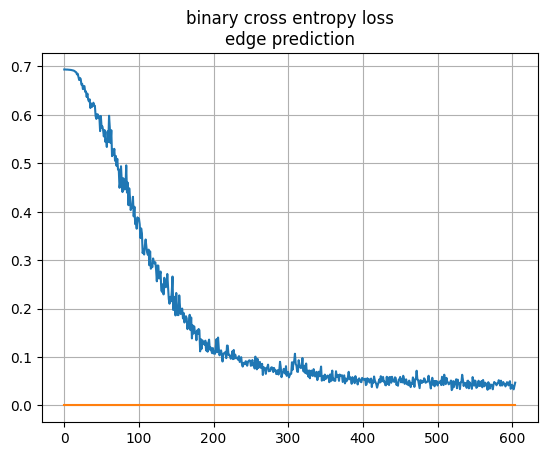

In [ ]:
FACTOR_SHORTCUT = 0.000
def eval_shortcut_loss(nw_out, node_inds_total):
    emb_nodes = tf.concat([emb_dr, emb_prot],0)
    _nodes = tf.gather(emb_nodes, node_inds_total)
    return tf.math.reduce_sum(tf.math.square(nw_out['nodes'] - _nodes)) * FACTOR_SHORTCUT

def eval_edge_loss(edge_labels, nw_out):
    return tf.losses.binary_crossentropy(edge_labels, nw_out['edges'][:,0], from_logits = True)

from IPython.display import clear_output

@tf.function(
    input_signature=[
        tf.TensorSpec(shape = (None), dtype=tf.int32),
        tf.TensorSpec(shape = (None), dtype=tf.int32),
        tf.TensorSpec(shape = (None), dtype=tf.int32),
        tf.TensorSpec(shape = (None), dtype=tf.int32),
        tf.TensorSpec(shape = (None), dtype=tf.float32)
    ]
)
def _train_step(
     edge_inds_total,
     node_inds_total, 
     senders_list, 
     receivers_list,
     edge_labels):

    with tf.GradientTape() as tape:
        tape.watch(emb_dr)
        tape.watch(emb_prot)
        emb_nodes = tf.concat([emb_dr, emb_prot],0)
        _gt = _make_gt(emb_nodes, emb_rel, 
                    edge_inds_total,node_inds_total,
                    senders_list, receivers_list)
        gt_res = nw(_gt)
        loss1 = eval_edge_loss(edge_labels, gt_res)
        loss2 = eval_shortcut_loss(gt_res, node_inds_total)
        loss = loss1 + loss2

    _losses = [loss1 , loss2]

    grads = tape.gradient(loss, [*nw.weights,emb_prot, emb_dr])
    opt.apply_gradients(zip(grads, [*nw.weights, emb_prot, emb_dr]))
    # grads1 = tape.gradient(loss1, nw.weights)
    # grads2 = tape.gradient(loss2, [emb_prot, emb_dr])
    # opt.apply_gradients(zip([*grads1, *grads2], [nw.weights, [emb_prot, emb_dr]]))
    return _losses, grads

num_drugs = 1200
for epoch in range(EPOCHS):
    # taking a random permutation of the drugs 
    # so that the simple "derangement" that is used for the negatives captures 
    # other negatives for each epoch. 
    rand_perm = np.random.choice(np.arange(num_drugs), num_drugs, replace = False)
    for batch_start in tqdm(range(0, num_drugs, BATCH_SIZE)):
        some_drugs = rand_perm[batch_start:batch_start  + BATCH_SIZE]
        drug_links, target_links = sample_neighborhood_of_drugs(some_drugs, prevent_backlink = False)
        edge_inds_total, node_inds_total, senders_list, receivers_list, edge_labels = \
           _graph_tuple_from_drug_subgraph(drug_links,target_links, include_backlinks=True)
        
        _losses,  grads = _train_step( np.concatenate(edge_inds_total,0).astype('int32'),
                                   np.concatenate(node_inds_total,0).astype('int32'),
                                   np.concatenate(senders_list,0).astype('int32'),
                                   np.concatenate(receivers_list,0).astype('int32'),
                                   edge_labels)

        losses.append([l.numpy() for l in _losses])
    # ckpt.checkpoint_model(epoch)
    clear_output()
    pplot.plot(np.array(losses)[:,0])
    pplot.plot(np.array(losses)[:,1])
    pplot.grid()
    pplot.title('binary cross entropy loss\nedge prediction')
    pplot.show()
    # break

## Inspecting embeddings

A t-SNE is plotted for the embeddings. It is expected, that drugs and proteins that "interact" somehow have similar embedings, and therefore belong in the same clusters. Visually, this should be observable in tSNE.

In [ ]:

def eval_partial_nw(g):
    # Evaluate up to the last layer used for the edge-discriminative task:
    g = nw.g_enc_determ.eval_tensor_dict(g)
    g = nw.g_core_determ[0].eval_tensor_dict(g)
    g = nw.g_core_determ[1].eval_tensor_dict(g)
    return g


In [ ]:
node_emb_data= dict()
for batch_start in range(0, num_drugs, BATCH_SIZE):
    some_drugs = rand_perm[batch_start:batch_start  + BATCH_SIZE]
    drug_links, target_links = sample_neighborhood_of_drugs(some_drugs, prevent_backlink = False, max_relations = 10)
    edge_inds_total, node_inds_total, senders_list, receivers_list, edge_labels = \
        _graph_tuple_from_drug_subgraph(drug_links,target_links, include_backlinks=True)
    emb_nodes = tf.concat([emb_dr, emb_prot],0)
    node_inds_c = np.concatenate(node_inds_total,0,dtype = 'int32')
    _gt = _make_gt(emb_nodes, emb_rel, 
                np.concatenate(edge_inds_total,0,dtype ='int32'),
                node_inds_c,
                np.concatenate(senders_list,0,dtype = 'int32' ),
                np.concatenate(receivers_list,0,dtype = 'int32'))
    # gt_res = nw(_gt)
    gt_res = eval_partial_nw(_gt)
    for n,v in zip(node_inds_c, gt_res['nodes'].numpy()):
        if n not in node_emb_data:
            node_emb_data[n] = v
    

# node_emb_data = np.concatenate(node_emb_data,0)

In [ ]:
arr = [] # numerival values of the embs.
key_idx = dict() # to map drug/proteins in the partial emb. result:
for i,(k,v) in enumerate(node_emb_data.items()):
    arr.append(v)
    key_idx[k] = i 
partial_emb_arr = np.stack(arr)

In [ ]:
res = TSNE().fit_transform(partial_emb_arr)

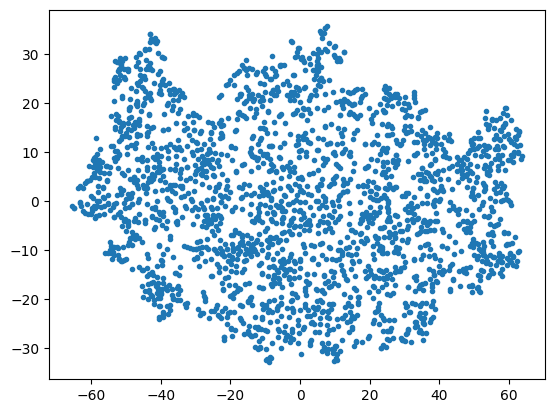

In [ ]:
pplot.plot(res[:,0], res[:,1],'.')

In [ ]:
items = [i for i in dict_drug_idx.items()]
drug_emb_inds = np.array([key_idx[v] for k, v in items if v in key_idx])
inv_index_drugs_local = {i : k for i,(k, v) in enumerate(items)}
drug_emb_partials = partial_emb_arr[drug_emb_inds]
res_drugs = res[drug_emb_inds]

In [ ]:
# for convenient links in the notebook:
class DrugbankEntry:
    def __init__(self,dbid):
        self.dbid = dbid

    def __repr__(self):
        return self.dbid

    def _repr_html_(self):
        return "<a href='https://go.drugbank.com/drugs/%s'>"%self.dbid + self.dbid + '</a>'

DB00715

In [ ]:
dict_drug_idx['DB01454']

197

interactive(children=(IntSlider(value=197, description='idx', max=500), IntSlider(value=10, description='n_sim…

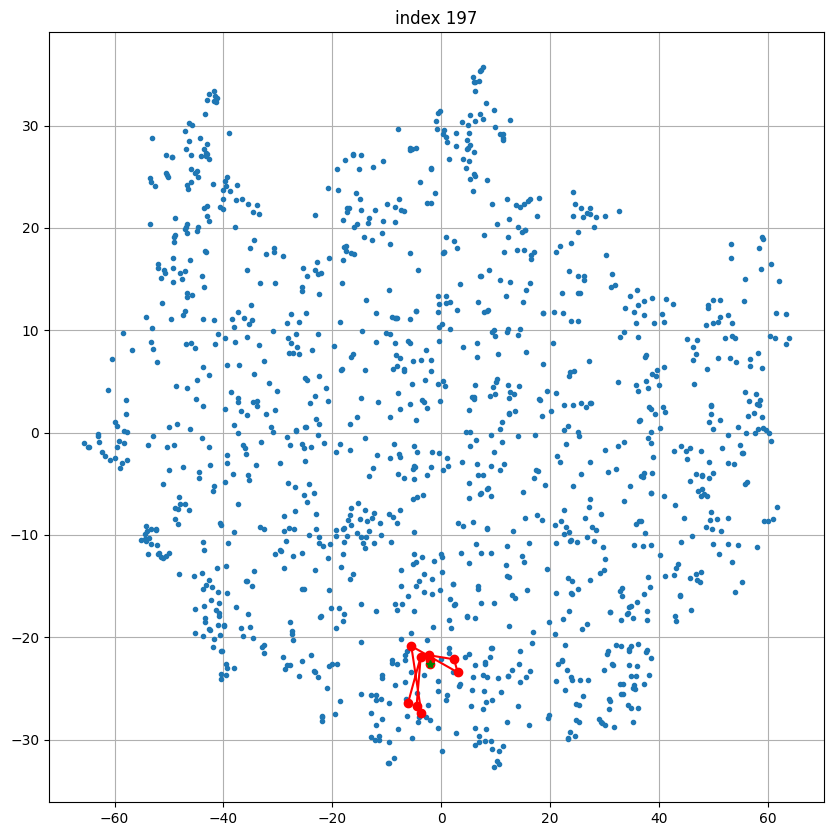

In [ ]:
from ipywidgets import IntSlider, interact, interactive
from IPython.display import display, HTML

@interact(idx = IntSlider(value = 197, min =  0 , max = 500))
def _plot_only_drugs_(idx, n_similars = 10):
    # get an index of a drug, 
    # compute the N neighbrs, 
    # plot nb, print nb
    dists = np.sum(np.square(drug_emb_partials[idx] - drug_emb_partials),1)
    closest = np.argsort(dists)[0:n_similars]
    clear_output()
    pplot.figure(figsize = (10,10))
    pplot.grid()
    pplot.plot(res_drugs[:,0],res_drugs[:,1],'.')
    pplot.plot(res_drugs[closest,0],res_drugs[closest,1],'or-')
    pplot.plot(res_drugs[closest[0],0],res_drugs[closest[0],1],'*g')
    pplot.title('index %i'%idx)

    dd = dbdata_f[dbdata_f.T.apply(lambda x : x['drugbank-id'] in set(map(lambda xx : inv_index_drugs_local[xx], closest )))]
    dd['drugbank-id'] = dd['drugbank-id'].apply(lambda x : DrugbankEntry(x))
    display(dd)
    for i,d in enumerate(dd['drugbank-id']):
        s = '<div> sim: %2.3f'%dists[closest][i]
        s += d._repr_html_()
        s += '</div>'
        display(HTML(s))
    
    # for c in closest:
    #     print(inv_index_drugs_local[c])
    

## Resources:
* TO CHECK: Predictive Toxicogenomics space : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5500850/
* AstraZeneca video:https://www.youtube.com/watch?v=qH3z5GwccxE